# 2) Analyze source collection and target file

This notebook includes the code to analyze the collection of sounds compiled in the previous notebook and that will be later used as the source collection in our audio mosaicing code. The notebook also contains the code to analyze the target audio file that will be later reconstructed using sound chunks from the source collection.

The audio analysis carried out in this notebook uses the Pythonn bindings of the Essentia library which was introduced in the first session of AMPLAB. Please make sure you checked the [Essentia Python tutorial](https://essentia.upf.edu/documentation/essentia_python_tutorial.html) to get familiarized with using Essentia in Python. Also useful is to always have a browser tab opened with Essentia's [Algorithms Reference](https://essentia.upf.edu/documentation/algorithms_reference.html) documentation page.

In [18]:
import pandas as pd
import essentia
import essentia.standard as estd
import matplotlib.pyplot as plt
from IPython.display import display, Audio

In [19]:
# Define here our sound analysis function
# NOTE: remember that if you update this function and want to run a new analysis you'll need to re-run both 
# this cell and the cells below that carry out the audio analysis and that call the analysis function. 
# After analyzing the source collection or the target file, make sure to correct descriptors have been 
# extracted by checking the DataFrame contents. DataFrame contents can be printed on screen as a table 
# using 'display(data_frame_object)'

def analyze_sound(audio_path, frame_size=None, audio_id=None):
    """Analyze the audio file given in 'sound_path'.
    Use the parameter 'frame_size' to set the size of the chunks in which the audio will 
    be split for analysis. If no frame_size is given, the whole audio will be analyzed as 
    a single frame.
    Use the 'audio_id' parameter to pass a custom identifier for the audio that will be 
    included in the analysis results. This can be useful to later identify to which file an analysis belongs.
    """
    analysis_output = []  # Here we'll store the analysis results for each chunk (frame) of the audio file
    
    # Load audio file
    loader = estd.MonoLoader(filename=audio_path)
    audio = loader()

    #Translating key into numbers so it's easier to find the nearest one
    key_number = {'F#':-5, 'C#':-4, 'G#':-3, 'D#':-2, 'A#':-1, 'F':0, 'C':1, 'G':2, 'D':3,'A':4, 'E':5, 'B':6,
                  'Gb':-5, 'Db':-4, 'Ab':-3, 'Eb':-2, 'Bb':-1} 

    # Extract tonality information
    key_algo = estd.KeyExtractor()
    key, scale, key_strength = key_algo(audio)
    
    # Extract beat positions
    beat_tracker_algo = estd.BeatTrackerDegara()
    beat_positions = beat_tracker_algo(audio) #time
    beat_positions = [int(round(position*44100)) for position in beat_positions] #frame numbers
    #print(beat_positions)
    
    # Extract onset positions
    onset_tracker = estd.OnsetRate()
    onset_positions, onset_rate = onset_tracker(audio)
    onset_positions = [int(round(position*44100)) for position in onset_positions] #frame numbers
    
    # Some processing of frame_size parameter to avoid later problems
    #if frame_size is None:
    #    frame_size = len(audio)  # If no frame_size is given use no frames (analyze all audio at once)
    #if frame_size % 2 != 0:
    #    frame_size = frame_size + 1 # Make frame size even
    
    #if it's the target file, use beat tracker for frame size
    #if audio_path == '4262350__stereo-surgeon__grinder-drum-loop.wav':
    #if audio_path == '82823__noisecollector__acoustic-flamenco-imitation.wav': 
    if audio_path == '417934__kamarin__music-box-clockwork-lullaby.wav':
        frame_start_samples = beat_positions#onset_positions#
    #if it's the source file, use onset detection.
    else:
        if len(audio) % 2 != 0:
            onset_positions.append(len(audio)-1)
        else:
            onset_positions.append(len(audio))
        #for i in range(0, len(onset_positions)):
        #    if onset_positions[i] % 2 != 0:
        #        onset_positions[i] = onset_positions[i] - 1
        frame_start_samples = onset_positions

    frame_start_end_samples = zip(frame_start_samples[:-1], frame_start_samples[1:])
    
    # Iterate over audio frames and analyze each one
    for count, (fstart, fend) in enumerate(frame_start_end_samples):
        # Get corresponding audio chunk and initialize dictionary to sotre analysis results with some basic metadata
        frame = audio[fstart:fend]
        frame_output = {
            'freesound_id': audio_id,
            'id': '{0}_f{1}'.format(audio_id, count),
            'path': audio_path,
            'start_sample': fstart,
            'end_sample': fend,
        }
        
        # Extract loudness
        loudness_algo = estd.Loudness()
        loudness = loudness_algo(frame)
        frame_output['loudness'] = loudness / len(frame)  # Normnalize by length of frame

        # Extract MFCC coefficients
        w_algo = estd.Windowing(type = 'hann')
        spectrum_algo = estd.Spectrum()
        mfcc_algo = estd.MFCC()
        spec = spectrum_algo(w_algo(frame))
        _, mfcc_coeffs = mfcc_algo(spec)
        frame_output.update({'mfcc_{0}'.format(j): mfcc_coeffs[j] for j in range(0, len(mfcc_coeffs))})
        
        # Extract other features here and add to 'frame_output' dictionary

        # Extract tonality information
        # The feature extraction for key is already done outside the recursion,
        # Now it's time to put them in the table

        frame_output['key'] = key
        frame_output['scale'] = scale
        frame_output['key strength'] = key_strength
        frame_output['key number'] = key_number[key]
        #rhythm_extractor = estd.RhythmExtractor2013(method="multifeature")
        #bpm, beats, beats_confidence, _, beats_intervals = rhythm_extractor(audio)
        #frame_output['bpm'] = bpm
        
        # Add frame analysis results to output
        analysis_output.append(frame_output)
        
    return analysis_output


## Analyze source collection

In [20]:
DATAFRAME_FILENAME = 'dataframe.csv'  # DataFrame file of the sound source collection to analyze
DATAFRAME_SOURCE_FILENAME = 'dataframe_source.csv'  # DataFrame file where to store the results of our analysis

# Load the DataFrame of the sound source collection created in previous notebook and analyze all sound files in it
df = pd.read_csv(open(DATAFRAME_FILENAME), index_col=0)
analyses = []
for i in range(0, len(df)):
    sound = df.iloc[i]  # Get DataFrame sound at position 'i'
    print('Analyzing sound with id {0} [{1}/{2}]'.format(sound['freesound_id'], i + 1, len(df)))
    analysis_output = analyze_sound(sound['path'], frame_size=8820, audio_id=sound['freesound_id'])  
    # Split audio in chunks of 200ms (44100/5 samples)
    analyses += analysis_output

# Store analysis results in a new Pandas DataFrame and save it
df_source = pd.DataFrame(analyses)
df_source.to_csv(DATAFRAME_SOURCE_FILENAME)
print('Saved source DataFrame with {0} entries! {1}'.format(len(df_source), DATAFRAME_SOURCE_FILENAME))

display(df_source)  # Show DataFrame contents
df_source.describe()  # Show some statistics of numerical fields in the DataFrame

Analyzing sound with id 333693 [1/60]
Analyzing sound with id 30160 [2/60]
Analyzing sound with id 216305 [3/60]
Analyzing sound with id 173000 [4/60]
Analyzing sound with id 318193 [5/60]
Analyzing sound with id 383593 [6/60]
Analyzing sound with id 434818 [7/60]
Analyzing sound with id 323129 [8/60]
Analyzing sound with id 258179 [9/60]
Analyzing sound with id 456565 [10/60]
Analyzing sound with id 254758 [11/60]
Analyzing sound with id 235265 [12/60]
Analyzing sound with id 121099 [13/60]
Analyzing sound with id 335090 [14/60]
Analyzing sound with id 425536 [15/60]
Analyzing sound with id 133043 [16/60]
Analyzing sound with id 171482 [17/60]
Analyzing sound with id 180278 [18/60]
Analyzing sound with id 366128 [19/60]
Analyzing sound with id 10430 [20/60]
Analyzing sound with id 381353 [21/60]
Analyzing sound with id 410516 [22/60]
Analyzing sound with id 331589 [23/60]
Analyzing sound with id 191633 [24/60]
Analyzing sound with id 139501 [25/60]
Analyzing sound with id 270090 [26/6

,end_sample,freesound_id,id,key,key number,key strength,loudness,mfcc_0,mfcc_1,mfcc_10,...,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,path,scale,start_sample
0,102464,333693,333693_f0,Ab,-3,0.561413,0.000163,-1093.523560,49.614697,-7.858107,...,-13.841595,-28.986721,-27.978848,-20.406258,-14.685875,-12.234688,-10.406555,files/333693_1187042-hq.ogg,minor,512
1,5120,30160,30160_f0,G,2,0.527126,0.002396,-1087.556885,-53.052826,10.289804,...,15.333109,-21.528263,6.303823,31.920689,-56.680618,64.008110,-39.668938,files/30160_129090-hq.ogg,minor,512
2,8192,30160,30160_f1,G,2,0.527126,0.001626,-1085.644775,-53.732269,5.897438,...,19.698729,-24.831827,8.031103,34.122604,-58.805870,65.547234,-36.412903,files/30160_129090-hq.ogg,minor,5120
3,15360,30160,30160_f2,G,2,0.527126,0.001574,-1030.327881,-76.999779,8.054930,...,46.545422,-16.309303,11.490839,31.509346,-35.841187,49.804001,-32.777412,files/30160_129090-hq.ogg,minor,8192
4,19968,30160,30160_f3,G,2,0.527126,0.001850,-1085.569214,-54.946625,1.435314,...,24.492188,-32.788589,11.746897,31.195215,-60.741528,65.474915,-36.827751,files/30160_129090-hq.ogg,minor,15360
5,23552,30160,30160_f4,G,2,0.527126,0.001388,-1090.060547,-52.872925,2.338198,...,16.609396,-25.195833,4.260571,31.660271,-58.721146,59.772106,-35.322269,files/30160_129090-hq.ogg,minor,19968
6,35840,30160,30160_f5,G,2,0.527126,0.000870,-1070.530273,-59.619076,9.978306,...,25.988117,-20.209497,12.171141,26.053764,-38.740677,51.225418,-31.483824,files/30160_129090-hq.ogg,minor,23552
7,39424,30160,30160_f6,G,2,0.527126,0.000591,-1090.469116,-47.520218,1.187004,...,24.040974,-28.938643,12.152710,29.004589,-53.127277,59.359413,-30.904062,files/30160_129090-hq.ogg,minor,35840
8,43520,30160,30160_f7,G,2,0.527126,0.002410,-1066.898315,-75.392746,6.385328,...,16.539988,-26.239136,11.385958,33.338478,-58.191917,65.529915,-35.009575,files/30160_129090-hq.ogg,minor,39424
9,48128,30160,30160_f8,G,2,0.527126,0.001957,-1069.362549,-72.264877,3.860312,...,16.614609,-27.399309,16.437439,26.769186,-52.044151,62.831131,-33.996071,files/30160_129090-hq.ogg,minor,43520


,end_sample,freesound_id,key number,key strength,loudness,mfcc_0,mfcc_1,mfcc_10,mfcc_11,mfcc_12,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,start_sample
count,308.000000,308.000000,308.000000,308.000000,3.080000e+02,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000
mean,53024.551948,225482.814935,0.574675,0.592625,2.339554e-03,-898.210962,74.499292,-1.064653,2.047392,-3.182756,5.719592,7.767352,-0.701264,0.238092,-4.950019,-6.894907,3.290842,-5.538720,36395.220779
std,32167.743183,128753.039563,2.491211,0.152088,3.099004e-03,154.499089,85.176667,17.472262,16.900879,17.068531,39.705976,32.809438,27.389519,29.055448,26.269139,23.635330,26.143238,18.674033,29594.493377
min,4608.000000,2821.000000,-5.000000,0.297549,9.185476e-07,-1138.420044,-121.450821,-46.455532,-49.295273,-59.894432,-104.865204,-83.560455,-80.354691,-96.287842,-77.961601,-63.057869,-59.348656,-54.574318,512.000000
25%,25856.000000,121230.000000,0.000000,0.460160,3.558883e-04,-1031.228943,0.164226,-12.814471,-9.691855,-12.855582,-16.611189,-13.048585,-17.088028,-19.385805,-20.335237,-22.172726,-13.503621,-16.926486,11264.000000
50%,49408.000000,254758.000000,1.000000,0.598673,1.130853e-03,-904.821838,86.068138,-1.229324,0.127430,-2.597174,9.810211,7.058998,-0.000061,1.596533,-2.498118,-5.096745,-0.098137,-3.829863,30720.000000
75%,71728.000000,341507.000000,2.000000,0.693636,3.016697e-03,-796.196136,138.191162,10.983984,12.585041,6.834717,29.699941,28.415195,16.398964,20.616494,16.846814,10.526507,18.389121,6.997495,56448.000000
max,132544.000000,460259.000000,6.000000,0.867389,2.352586e-02,-498.394623,243.724594,71.385948,51.247940,56.616920,111.061211,109.173172,84.262421,76.699890,48.140434,51.178726,83.510506,53.517731,126464.000000


## Analyze the target sound file

Analyzing target sound 417934__kamarin__music-box-clockwork-lullaby.wav
Saved target dataframe with 25 entries! dataframe_target.csv


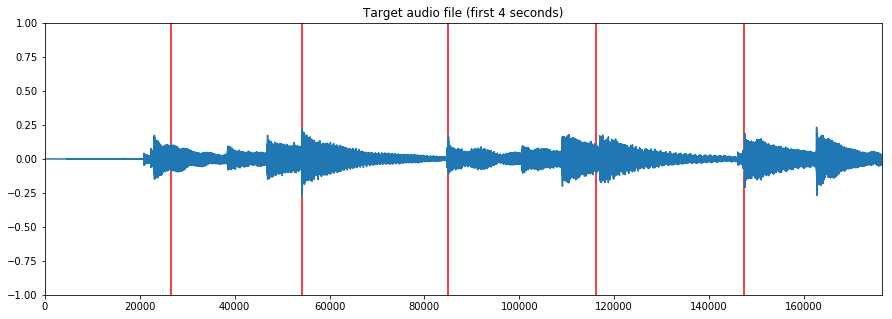

,end_sample,freesound_id,id,key,key number,key strength,loudness,mfcc_0,mfcc_1,mfcc_10,...,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,path,scale,start_sample
0,54272,None,None_f0,C,1,0.710031,0.000446,-992.474792,57.067513,-32.747856,...,-76.266487,-13.296795,26.698097,26.355278,16.907633,37.737293,8.296427,417934__kamarin__music-box-clockwork-lullaby.wav,major,26624
1,84992,None,None_f1,C,1,0.710031,0.000375,-1039.266357,42.112072,-55.375324,...,-59.327248,4.401093,14.252403,11.398243,42.241631,43.147892,-29.008736,417934__kamarin__music-box-clockwork-lullaby.wav,major,54272
2,116224,None,None_f2,C,1,0.710031,0.000509,-1018.015930,45.352764,-17.405035,...,-66.609200,15.196274,55.575745,24.814899,-1.054153,12.145954,3.293564,417934__kamarin__music-box-clockwork-lullaby.wav,major,84992
3,147456,None,None_f3,C,1,0.710031,0.000365,-1045.916626,42.622478,-53.312901,...,-62.195168,17.203461,30.381088,7.651295,24.649622,40.315472,-8.282303,417934__kamarin__music-box-clockwork-lullaby.wav,major,116224
4,178688,None,None_f4,C,1,0.710031,0.000599,-947.995728,39.527569,-7.852823,...,-55.149036,-12.242838,-36.500599,-9.102583,17.276371,60.962517,37.425846,417934__kamarin__music-box-clockwork-lullaby.wav,major,147456
5,209920,None,None_f5,C,1,0.710031,0.000830,-963.435974,65.540581,46.141506,...,-84.231758,-16.217113,31.903000,13.205341,-14.595955,-8.948936,42.105568,417934__kamarin__music-box-clockwork-lullaby.wav,major,178688
6,241664,None,None_f6,C,1,0.710031,0.000360,-1013.394104,72.687698,28.365612,...,-97.188850,-16.681438,30.641624,-7.829414,-17.019608,1.854507,39.944603,417934__kamarin__music-box-clockwork-lullaby.wav,major,209920
7,272896,None,None_f7,C,1,0.710031,0.000255,-1040.920044,73.632362,13.114666,...,-88.234261,-37.044186,24.877914,33.989021,12.649828,5.266026,12.293001,417934__kamarin__music-box-clockwork-lullaby.wav,major,241664
8,304128,None,None_f8,C,1,0.710031,0.000443,-1001.746460,69.203621,-29.732061,...,-83.260841,-20.612408,20.733360,24.074512,18.994150,42.817898,20.940020,417934__kamarin__music-box-clockwork-lullaby.wav,major,272896
9,335360,None,None_f9,C,1,0.710031,0.000389,-1032.130859,45.347485,-49.269367,...,-53.490242,6.914658,13.670052,12.184925,43.901665,48.256718,-21.620049,417934__kamarin__music-box-clockwork-lullaby.wav,major,304128


,end_sample,key number,key strength,loudness,mfcc_0,mfcc_1,mfcc_10,mfcc_11,mfcc_12,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,start_sample
count,25.00000,25.0,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,429219.84000,1.0,0.710031,0.000470,-1009.639304,55.231030,-12.086029,-4.721127,25.275045,-84.463430,-69.501963,-3.657743,22.469758,11.002358,7.999184,25.921354,18.109321,398049.280000
std,230342.99597,0.0,0.000000,0.000177,34.000596,13.088950,27.355041,14.560532,18.116766,24.121237,15.969906,17.640429,16.783917,17.002123,17.128583,19.668926,21.588445,229973.178815
min,54272.00000,1.0,0.710031,0.000061,-1078.430908,34.536449,-55.841648,-28.545071,-14.286518,-118.755493,-97.188850,-37.044186,-36.500599,-20.285667,-17.019608,-8.948936,-29.008736,26624.000000
25%,241664.00000,1.0,0.710031,0.000365,-1035.979492,42.756359,-29.199190,-16.125126,14.866962,-105.416336,-81.945259,-16.217113,14.252403,-0.870586,-5.103516,5.413219,3.293564,209920.000000
50%,429568.00000,1.0,0.710031,0.000504,-1013.394104,57.067513,-16.287035,-6.584480,28.787075,-85.855019,-69.244980,-7.613323,24.877914,7.712162,6.680010,27.313435,20.940020,398336.000000
75%,616448.00000,1.0,0.710031,0.000599,-990.998535,65.540581,10.244068,9.137238,40.580456,-77.979065,-56.712013,10.101578,30.381088,24.814899,17.276371,42.817898,34.854446,584704.000000
max,805888.00000,1.0,0.710031,0.000830,-947.995728,75.642319,46.141506,17.080185,48.196590,-34.104870,-38.717644,30.943592,55.575745,44.764870,43.901665,60.962517,48.461666,774144.000000


In [21]:
#EXAMPLE:
#TARGET_SOUND_PATH = '262350__stereo-surgeon__grinder-drum-loop.wav'  # Filename of the target audio we'll reconstruct
#TARGET_SOUND_PATH = '82823__noisecollector__acoustic-flamenco-imitation.wav'
TARGET_SOUND_PATH = '417934__kamarin__music-box-clockwork-lullaby.wav'

DATAFRAME_TARGET_FILE_FILENAME = 'dataframe_target.csv'  # DataFrame file where to store the analysis results of the target audio

# Analyze the target audio file and store results in a new DataFrame
print('Analyzing target sound {0}'.format(TARGET_SOUND_PATH))

target_analysis = analyze_sound(TARGET_SOUND_PATH, frame_size = 8820)  # Also split audio in chunks of 200ms (44100/5 samples) 
df_target = pd.DataFrame(target_analysis)
df_target.to_csv(DATAFRAME_TARGET_FILE_FILENAME)
print('Saved target dataframe with {0} entries! {1}'.format(len(df_target), DATAFRAME_TARGET_FILE_FILENAME))

# Plot target audio file waveform and show ticks at the start samples of the chunks
plt.figure(figsize=(15,5))
audio = estd.MonoLoader(filename=TARGET_SOUND_PATH)()
plt.plot(audio)
plt.vlines(df_target['start_sample'].values, -1, 1, color='red')
plt.axis([0, min(len(audio), 44100 * 4), -1, 1])
plt.title('Target audio file (first 4 seconds)')
plt.show()

display(df_target)  # Show data frame contents

df_target.describe()  # Show statistics of numerical fields in data frame

In [22]:
#######################################################
#FILTERING THE SOURCE FILES WITH THE KEY OF TARGET FILE
#######################################################

#Get the key number of target
target_key_number = df_target["key number"][0]

#Get the most similar two keys
left = target_key_number-1
right = target_key_number+1
#Two exceptions
if target_key_number == 6: right = -5
if target_key_number == -5: left = 6

#Only keep the source sample that has the same key, or the two nearest keys
three_nearest_keys = [left, target_key_number, right]
filtered_df = df_source.loc[df_source['key number'].isin(three_nearest_keys)]
#display(filtered_df)

#If after filtering the dataframe became empty, then keep the original df_source
if len(filtered_df.index)!=0:
    df_source = filtered_df

display(df_source)


,end_sample,freesound_id,id,key,key number,key strength,loudness,mfcc_0,mfcc_1,mfcc_10,...,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,path,scale,start_sample
1,5120,30160,30160_f0,G,2,0.527126,0.002396,-1087.556885,-53.052826,10.289804,...,15.333109,-21.528263,6.303823,31.920689,-56.680618,64.008110,-39.668938,files/30160_129090-hq.ogg,minor,512
2,8192,30160,30160_f1,G,2,0.527126,0.001626,-1085.644775,-53.732269,5.897438,...,19.698729,-24.831827,8.031103,34.122604,-58.805870,65.547234,-36.412903,files/30160_129090-hq.ogg,minor,5120
3,15360,30160,30160_f2,G,2,0.527126,0.001574,-1030.327881,-76.999779,8.054930,...,46.545422,-16.309303,11.490839,31.509346,-35.841187,49.804001,-32.777412,files/30160_129090-hq.ogg,minor,8192
4,19968,30160,30160_f3,G,2,0.527126,0.001850,-1085.569214,-54.946625,1.435314,...,24.492188,-32.788589,11.746897,31.195215,-60.741528,65.474915,-36.827751,files/30160_129090-hq.ogg,minor,15360
5,23552,30160,30160_f4,G,2,0.527126,0.001388,-1090.060547,-52.872925,2.338198,...,16.609396,-25.195833,4.260571,31.660271,-58.721146,59.772106,-35.322269,files/30160_129090-hq.ogg,minor,19968
6,35840,30160,30160_f5,G,2,0.527126,0.000870,-1070.530273,-59.619076,9.978306,...,25.988117,-20.209497,12.171141,26.053764,-38.740677,51.225418,-31.483824,files/30160_129090-hq.ogg,minor,23552
7,39424,30160,30160_f6,G,2,0.527126,0.000591,-1090.469116,-47.520218,1.187004,...,24.040974,-28.938643,12.152710,29.004589,-53.127277,59.359413,-30.904062,files/30160_129090-hq.ogg,minor,35840
8,43520,30160,30160_f7,G,2,0.527126,0.002410,-1066.898315,-75.392746,6.385328,...,16.539988,-26.239136,11.385958,33.338478,-58.191917,65.529915,-35.009575,files/30160_129090-hq.ogg,minor,39424
9,48128,30160,30160_f8,G,2,0.527126,0.001957,-1069.362549,-72.264877,3.860312,...,16.614609,-27.399309,16.437439,26.769186,-52.044151,62.831131,-33.996071,files/30160_129090-hq.ogg,minor,43520
10,52736,30160,30160_f9,G,2,0.527126,0.002246,-1081.487793,-56.873329,4.084095,...,24.903957,-30.007513,11.224031,36.137627,-63.057869,70.368469,-37.400105,files/30160_129090-hq.ogg,minor,48128
